# Import the relevant libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Import the dataset

### Split the Dataset into training and testing

In [3]:
DIR = "WasteImagesDataset/"

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, 
                                                                    subset="training", seed=42, 
                                                                    batch_size=16, smart_resize=True)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1,
                                                                  subset="validation", seed=42,
                                                                  batch_size=16, smart_resize=True)

Found 5617 files belonging to 9 classes.
Using 5056 files for training.
Found 5617 files belonging to 9 classes.
Using 561 files for validation.


### Optimise the training and testing performance

In [4]:
classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes, numClasses)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood'] 9


### Performing Data Augmentation

In [5]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.inception_v3.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# model

### Resnet152 Model 

In [6]:
baseModel = tf.keras.applications.ResNet152(input_shape=(256, 256, 3), weights='imagenet',
                                           include_top=False, classes=numClasses)

for layers in baseModel.layers:
    layers.trainable=False
    
last_output = baseModel.layers[-1].output

x = tf.keras.layers.Dropout(0.5)(last_output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input, outputs=x)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])

epochs=10
callbacks = tf.keras.callbacks.EarlyStopping(patience=2)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[callbacks])

Epoch 1/10
316/316 [==============================] - 2150s 7s/step - loss: 0.8157 - accuracy: 0.7785 - val_loss: 0.4792 - val_accuracy: 0.8467
Epoch 2/10
316/316 [==============================] - 2185s 7s/step - loss: 0.1492 - accuracy: 0.9484 - val_loss: 0.4693 - val_accuracy: 0.8859
Epoch 3/10
316/316 [==============================] - 2218s 7s/step - loss: 0.0583 - accuracy: 0.9816 - val_loss: 0.5414 - val_accuracy: 0.8948
Epoch 4/10
316/316 [==============================] - 2213s 7s/step - loss: 0.0381 - accuracy: 0.9873 - val_loss: 0.5610 - val_accuracy: 0.8895


In [9]:
import h5py

model.save('model_with_history.h5')

with h5py.File('model_with_history.h5', 'a') as hf:
    for key in history.history.keys():
        hf.create_dataset(key, data=history.history[key])

# Testing

1/1 [==============================] - 4s 4s/step
[1.9455925e-08 2.0564160e-04 3.8106931e-09 6.4323544e-08 7.3818718e-10
 9.9999657e+01 1.8782895e-10 4.8869048e-14 1.3826361e-04] 
 ['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']
Prediction:  Paper and Cardboard 99.9996542930603%


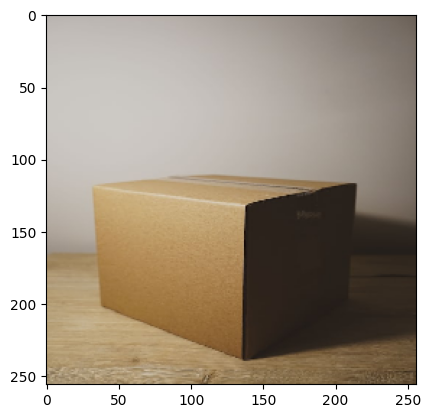

In [10]:
url = "https://images.unsplash.com/photo-1577705998148-6da4f3963bc8?ixid=MnwxMjA3fDB8MHxzZWFyY2h8Nnx8Y2FyZGJvYXJkfGVufDB8fDB8fA%3D%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60"
image = tf.keras.utils.get_file("Image1.jpg", origin=url)

img = tf.keras.preprocessing.image.load_img(image, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

1/1 [==============================] - 0s 457ms/step
[8.2333962e-04 1.3029186e-08 2.7664487e+00 1.6310258e-05 3.1470159e-07
 1.9013401e-05 9.7232697e+01 4.1172240e-07 2.8617874e-06] 
 ['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']
Prediction:  Plastic 97.23269939422607%


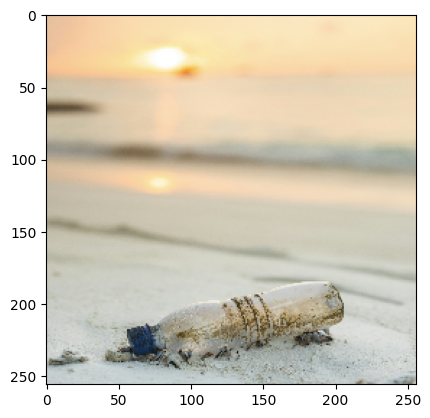

In [11]:
url = "https://images.unsplash.com/photo-1534962303837-2edd16492781?q=80&w=1664&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
image = tf.keras.utils.get_file("test1_bottle.avif", origin=url)

img = tf.keras.preprocessing.image.load_img(image, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

1/1 [==============================] - 1s 617ms/step
[3.6770492e-03 2.9435391e-03 9.9349197e+01 7.2570852e-05 5.5023134e-01
 2.3837072e-05 9.3668900e-02 1.8174203e-04 4.9611760e-08] 
 ['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']
Prediction:  Glass 99.34919476509094%


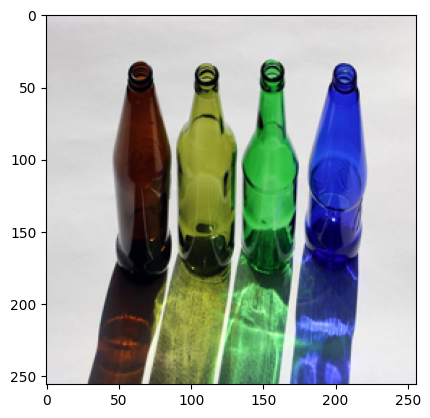

In [29]:

url = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/11/Beer_bottles_2018_G1.jpg/1280px-Beer_bottles_2018_G1.jpg"

response = requests.get(url)
image = Image.open(io.BytesIO(response.content))

image = image.resize((256, 256))

img_array = tf.keras.preprocessing.image.img_to_array(image)
img_array = tf.expand_dims(img_array, 0)


predictions = model.predict(img_array)

plt.imshow(image)

print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

# Confusion Matrix

In [18]:
print(os.getcwd())

D:\EightSem\Project with more images\Waste_Classification_ResNet152


1/1 [==============================] - 1s 645ms/step


<Figure size 1000x1000 with 0 Axes>

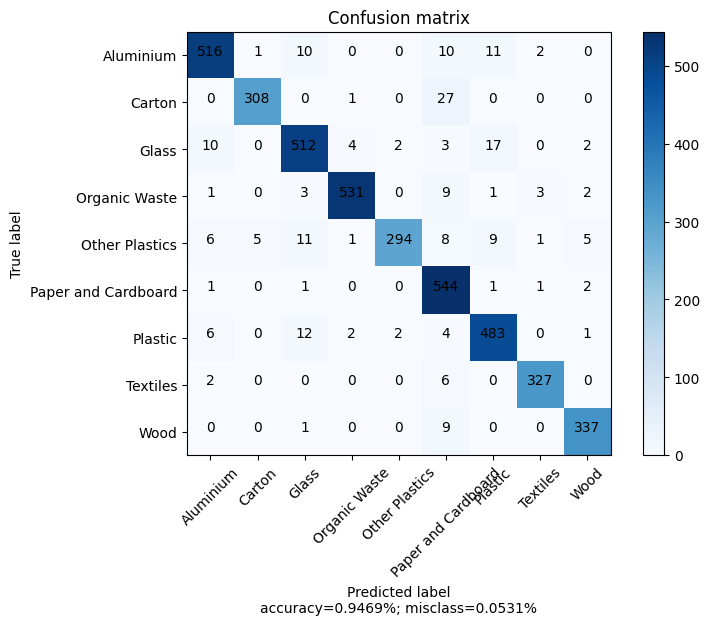

In [19]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

path = "WasteImagesDataset/"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:550]:
    fullPath = os.path.join(folderPath, j)
    try:
      img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0) 

      preds = model.predict(img_array)
      true.append(classes.index(i))
      predictions.append(np.argmax(preds))
    except:
      print("Error on image:", fullPath)

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)